In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas_profiling

import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, classification_report

from sklearn.ensemble import GradientBoostingClassifier

# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

/var/folders/rt/h59slvxd0c54py8vndb3fm8h0000gn/T/ipykernel_62923/2551231302.py:4: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [3]:
try:
    df_train = pd.read_csv('/kaggle/input/yap15-heart-diseases-predictions/train.csv',index_col=0)
    df_test = pd.read_csv('/kaggle/input/yap15-heart-diseases-predictions/test.csv',index_col=0)
except:
    df_train = pd.read_csv('./train.csv',index_col=0)
    df_test = pd.read_csv('./test.csv',index_col=0)
    
display(df_train.head())
display(df_test.head())
display(df_train.columns)
display(df_train.info())
print('Размер  тренировочной таблицы:', df_train.shape)
print('Размер  тестовой таблицы:', df_test.shape)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
id,,,,,,,,,,,
5,18888,1,154,85.0,130,80,1,1,0,0,1
6,19042,2,170,69.0,130,90,1,1,0,0,1
7,20432,1,160,70.0,120,75,1,1,0,0,0
10,18133,2,185,94.0,130,90,1,1,0,0,1
11,16093,2,170,76.0,120,80,1,1,0,0,1


Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


None

Размер  тренировочной таблицы: (70000, 12)
Размер  тестовой таблицы: (30000, 11)


In [4]:
df_train.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [5]:
df_test.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
dtype: int64

In [6]:
# profile=pandas_profiling.ProfileReport(df_train)
# profile

In [7]:
df_train.corr()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
age,1.000000,-0.022811,-0.081515,0.053684,0.020764,0.017647,0.154424,0.098703,-0.047633,-0.029723,-0.009927,0.238159
gender,-0.022811,1.000000,0.499033,0.155406,0.006005,0.015254,-0.035821,-0.020491,0.338135,0.170966,0.005866,0.008109
height,-0.081515,0.499033,1.000000,0.290968,0.005488,0.006150,-0.050226,-0.018595,0.187989,0.094419,-0.006570,-0.010821
weight,0.053684,0.155406,0.290968,1.000000,0.030702,0.043710,0.141768,0.106857,0.067780,0.067113,-0.016867,0.181660
ap_hi,0.020764,0.006005,0.005488,0.030702,1.000000,0.016086,0.023778,0.011841,-0.000922,0.001408,-0.000033,0.054475
ap_lo,0.017647,0.015254,0.006150,0.043710,0.016086,1.000000,0.024019,0.010806,0.005186,0.010601,0.004780,0.065719
cholesterol,0.154424,-0.035821,-0.050226,0.141768,0.023778,0.024019,1.000000,0.451578,0.010354,0.035760,0.009911,0.221147
gluc,0.098703,-0.020491,-0.018595,0.106857,0.011841,0.010806,0.451578,1.000000,-0.004756,0.011246,-0.006770,0.089307
smoke,-0.047633,0.338135,0.187989,0.067780,-0.000922,0.005186,0.010354,-0.004756,1.000000,0.340094,0.025858,-0.015486
alco,-0.029723,0.170966,0.094419,0.067113,0.001408,0.010601,0.035760,0.011246,0.340094,1.000000,0.025476,-0.007330


In [8]:
df_train.duplicated().sum(), df_test.duplicated().sum() 

(24, 6)

In [9]:
# dropping duplicates

df_train.drop_duplicates(keep='first', inplace=True)
df_test.drop_duplicates(keep='first', inplace=True)    

In [10]:
for df in (df_train,df_test): print(df.duplicated().sum()) 

0
0


In [11]:
# labling gender to binary values

df_train['gender'] = df_train['gender'].map({1: 0, 2: 1})
df_test['gender'] = df_test['gender'].map({1: 0, 2: 1})

In [12]:
# converting age from days to years

df_train['age'] = df_train['age'] / 365.25
df_train['age'] = df_train['age'].astype(int)

df_test['age'] = df_test['age'] / 365.25
df_test['age'] = df_test['age'].astype(int)

In [13]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,69976.0,52.803475,6.762773,29.0,48.0,53.0,58.0,64.0
gender,69976.0,0.349648,0.476862,0.0,0.0,0.0,1.0,1.0
height,69976.0,164.359152,8.211218,55.0,159.0,165.0,170.0,250.0
weight,69976.0,74.208519,14.397211,10.0,65.0,72.0,82.0,200.0
ap_hi,69976.0,128.820453,154.037729,-150.0,120.0,120.0,140.0,16020.0
ap_lo,69976.0,96.636261,188.504581,-70.0,80.0,80.0,90.0,11000.0
cholesterol,69976.0,1.366997,0.680333,1.0,1.0,1.0,2.0,3.0
gluc,69976.0,1.226535,0.572353,1.0,1.0,1.0,1.0,3.0
smoke,69976.0,0.088159,0.283528,0.0,0.0,0.0,0.0,1.0
alco,69976.0,0.053790,0.225604,0.0,0.0,0.0,0.0,1.0


Column check shows:
 - age is ok
 - gender is binary now
 - height has outliners
 - weight has outliners 
 - arterial pressure populated with negative and high values
 - others sims ok

In [14]:
wrong_weight = df_train[df_train['weight'] <= 30]
display(wrong_weight.head())

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
5306,42,0,120,30.0,110,70,1,1,0,0,1,0
26503,49,0,160,30.0,120,80,1,1,0,0,1,1
38312,63,0,157,23.0,110,80,1,1,0,0,1,0
42156,55,1,177,22.0,120,80,1,1,1,1,1,0
48318,59,1,178,11.0,130,90,1,1,0,0,1,1


In [15]:
df_train.loc[df_train[df_train['weight'] <= 30].index, 'weight'] = df_train['weight'].median()
df_test.loc[df_test[df_test['weight'] <= 30].index, 'weight'] = df_train['weight'].median()

In [16]:
big_height = df_train[df_train['height'] > 220]
display(big_height.head())
small_height = df_train[df_train['height'] < 100]
display(small_height.head())

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
9223,58,0,250,86.0,140,100,3,1,0,0,1,1


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
309,59,1,76,55.0,120,80,1,1,0,0,1,0
10843,40,1,70,72.0,120,8,1,1,0,0,1,0
11662,48,1,97,170.0,160,100,1,1,1,0,1,1
18218,53,0,75,168.0,120,80,1,1,1,0,1,1
18928,61,1,71,68.0,120,80,3,1,0,0,1,0


In [17]:
df_train.loc[df_train.query('height > 220').index, 'height'] = df_train['height'].median()
df_test.loc[df_test.query('height > 220').index, 'height'] = df_train['height'].median()

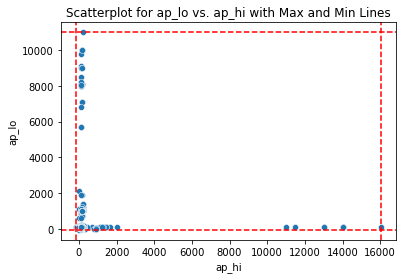

In [18]:
def ap_plot(df):
    sns.scatterplot(data=df_train, x="ap_hi", y="ap_lo")


    max_ap_hi = df["ap_hi"].max()
    min_ap_hi = df["ap_hi"].min()
    max_ap_lo = df["ap_lo"].max()
    min_ap_lo = df["ap_lo"].min()

    # добавляем вертикальные линии
    plt.axvline(x=max_ap_hi, color='r', linestyle='--')
    plt.axvline(x=min_ap_hi, color='r', linestyle='--')

    # добавляем горизонтальные линии
    plt.axhline(y=max_ap_lo, color='r', linestyle='--')
    plt.axhline(y=min_ap_lo, color='r', linestyle='--')

    # добавляем подписи к осям и заголовок графика
    plt.xlabel("ap_hi")
    plt.ylabel("ap_lo")
    plt.title("Scatterplot for ap_lo vs. ap_hi with Max and Min Lines")

    # показываем график
    plt.show()
ap_plot(df_train)

In [19]:
display(df_train.loc[df_train['ap_lo'] > df_train['ap_hi']].sample(10))

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
64128,61,0,148,74.0,180,902,2,2,0,0,1,1
48206,56,0,157,84.0,11,70,1,1,0,0,1,0
22881,60,1,161,90.0,-115,70,1,1,0,0,1,0
86388,56,1,163,82.0,162,1100,1,1,0,0,1,1
76966,50,0,174,58.0,140,1000,1,1,0,0,1,1
51995,51,1,167,87.0,150,1000,1,1,0,0,1,1
20023,52,1,162,59.0,160,1000,1,1,0,0,1,1
19095,60,0,160,84.0,140,1100,3,3,0,0,1,1
88851,57,0,160,78.0,160,1000,1,1,0,0,1,1


In [20]:
for df in (df_train,df_test):
    df['ap_hi'] = df['ap_hi'].abs()
    df['ap_lo'] = df['ap_lo'].abs()

In [21]:
# wrong placing of arterial pressure when ap_lo is higher than ap_hi
for df in (df_train,df_test):
    mask = df['ap_lo'] > df['ap_hi']
    df.loc[mask, ['ap_lo', 'ap_hi']] = df.loc[mask, ['ap_hi', 'ap_lo']].values

In [22]:
def ap_hi(row):
      
    if row['ap_hi'] > 260 and row['ap_hi'] <= 2000:
        ap_hi = int(row['ap_hi'] / 10)
        row['ap_hi'] = ap_hi
    elif row['ap_hi'] > 2000:
        ap_hi = int(row['ap_hi'] / 100)
        row['ap_hi'] = ap_hi
        
    return row

for df in (df_train,df_test): df = df.apply(ap_hi, axis=1)

In [23]:
for df in (df_train,df_test):
    df.loc[df['ap_lo'] > 150, 'ap_lo'] /= 10
    df.loc[df['ap_hi'] > 4000, 'ap_hi'] /= 100

In [24]:
nul_ap_hi = df_train[df_train['ap_hi'] == 0]
display(nul_ap_hi.head())
nul_ap_lo = df_train[df_train['ap_lo'] == 0]
display(nul_ap_lo.head())

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
2845,62,1,167,59.0,906.0,0.0,1,1,0,0,1,0
19258,40,1,150,60.0,130.0,0.0,1,1,0,0,0,0
23512,56,0,156,50.0,138.0,0.0,3,1,0,0,1,1
24837,49,0,164,78.0,138.0,0.0,1,1,0,0,1,0
32749,57,1,166,68.0,149.0,0.0,1,1,0,0,1,1


In [25]:
df_train.loc[nul_ap_lo.index, 'ap_lo'] = None
df_train['ap_lo'] = df_train['ap_lo'].fillna(df_train['ap_lo'].median())
display(df_train.loc[nul_ap_lo.index].head())

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
2845,62,1,167,59.0,906.0,80.0,1,1,0,0,1,0
19258,40,1,150,60.0,130.0,80.0,1,1,0,0,0,0
23512,56,0,156,50.0,138.0,80.0,3,1,0,0,1,1
24837,49,0,164,78.0,138.0,80.0,1,1,0,0,1,0
32749,57,1,166,68.0,149.0,80.0,1,1,0,0,1,1


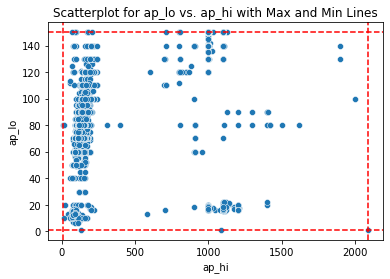

In [26]:
ap_plot(df_train)

In [27]:
df_train.query('ap_hi > 500').count()['age']

958

Arterial pressure is better but there is a way to improve

In [28]:
# introducing bmi index
for df in (df_train,df_test): df['bmi'] = df['weight']/(df['height']/100)**2

In [29]:
# deleting hieght and weight as they correlate with bmi
for df in (df_train,df_test): df.drop(columns=['height', 'weight'], inplace=True)

In [30]:
df_train.shape

(69976, 11)

In [31]:
df_test.shape

(29994, 10)

In [32]:
print(df_train['cardio'].value_counts())

0    35004
1    34972
Name: cardio, dtype: int64


In [33]:
categorical_features = ['gender', 'smoke', 'alco', 'active']
int_features = ['age','ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'cardio']
df_train[categorical_features] = df_train[categorical_features].astype('category')
df_train[int_features] = df_train[int_features].astype('int64')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69976 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          69976 non-null  int64   
 1   gender       69976 non-null  category
 2   ap_hi        69976 non-null  int64   
 3   ap_lo        69976 non-null  int64   
 4   cholesterol  69976 non-null  int64   
 5   gluc         69976 non-null  int64   
 6   smoke        69976 non-null  category
 7   alco         69976 non-null  category
 8   active       69976 non-null  category
 9   cardio       69976 non-null  int64   
 10  bmi          69976 non-null  float64 
dtypes: category(4), float64(1), int64(6)
memory usage: 6.6 MB


In [34]:
df_train_numeric = df_train.select_dtypes(include=[np.number])
df_train_numeric_cols = df_train_numeric.columns.values.tolist()
print('Столбцы с количественными признаками тренировочная выборка: \n', df_train_numeric_cols)

Столбцы с количественными признаками тренировочная выборка: 
 ['age', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'cardio', 'bmi']


In [35]:
features_train = df_train.drop(['cardio'], axis=1)
target_train = df_train['cardio']

In [36]:
sc = MinMaxScaler()
features_train_sc = features_train.copy()
features_train_sc[['age', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'bmi']] = \
sc.fit_transform(features_train[['age', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'bmi']])

features_test_sc = df_test.copy()
features_test_sc[['age', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'bmi']] = \
sc.transform(features_test_sc[['age', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'bmi']])

In [ ]:
%%timeit

grb = GradientBoostingClassifier(random_state=23)
param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}
# rs_grb = GridSearchCV(grb, 
#                                param_grid=param_distributions, 
#                                cv=5, 
#                                n_jobs=-1, 
#                                verbose=2,
#                                scoring='roc_auc')
rs_grb = RandomizedSearchCV(grb, 
                               param_distributions=param_distributions, 
                               cv=5, 
                               n_iter=20, 
                               n_jobs=-1, 
                               random_state=23,
                               verbose=2,
                               scoring='roc_auc')

rs_grb.fit(features_train_sc, target_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
print('Оптимальные параметры GradientBoostingClassifier: ', rs_grb.best_params_)
print()
print('Лучший показатель AUC_ROC GradientBoostingClassifier:', rs_grb.best_score_)

In [ ]:
predictions = grb.predict(features_test_sc)

to_submit = pd.DataFrame(index=features_test_sc.index)
to_submit['cardio'] = predictions
to_submit['cardio'] = to_submit['cardio'].astype('float16')
to_submit.to_csv('submission.csv')
print(to_submit.shape)

In [ ]:
from joblib import dump
dump(grb, 'heart.model')

In [ ]:
to_submit.head()